## Импорты и настройки

In [1]:
import numpy as np
import pandas as pd

Для графиков:

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt

Дополнительно:

In [3]:
import time
from tqdm import tqdm, trange

Для разделения данных:

In [4]:
from sklearn.model_selection import train_test_split

Модели:

In [5]:
from ensembles import RMSE, RandomForestMSE, GradientBoostingMSE

Настроим отображение графиков:

In [6]:
plt.rc('axes', axisbelow=True, grid=True)
plt.rc('grid', c='grey', ls=':')
plt.rc('savefig', bbox='tight', pad_inches=0.1, format='pdf')
opt_color = 'mediumspringgreen'

Директории (для данных, для бинарных файлов numpy, для графиков pdf):

In [7]:
data_dir = '../data/'
bin_dir = 'bin/'
graph_dir = 'graphics/'

## 1. Загрузка и предобработка данных

In [8]:
data = pd.read_csv(data_dir + 'kc_house_data.csv', index_col=0)
data

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
id,,,,,,,,,,,,,,,,,,,,
7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
263000018,20140521T000000,360000.0,3,2.50,1530,1131,3.0,0,0,3,8,1530,0,2009,0,98103,47.6993,-122.346,1530,1509
6600060120,20150223T000000,400000.0,4,2.50,2310,5813,2.0,0,0,3,8,2310,0,2014,0,98146,47.5107,-122.362,1830,7200
1523300141,20140623T000000,402101.0,2,0.75,1020,1350,2.0,0,0,3,7,1020,0,2009,0,98144,47.5944,-122.299,1020,2007


Выделяем в `y` целевую переменную - колонку `price` и убираем эту колонку из выборки; далее правим формат времени в колонке `date`:

In [9]:
y = data['price'].to_frame()
X = data.drop(columns=['price'])
X['date'] = pd.to_datetime(X['date'])

In [10]:
X

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
id,,,,,,,,,,,,,,,,,,,
7129300520,2014-10-13,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
6414100192,2014-12-09,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
5631500400,2015-02-25,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2487200875,2014-12-09,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
1954400510,2015-02-18,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
263000018,2014-05-21,3,2.50,1530,1131,3.0,0,0,3,8,1530,0,2009,0,98103,47.6993,-122.346,1530,1509
6600060120,2015-02-23,4,2.50,2310,5813,2.0,0,0,3,8,2310,0,2014,0,98146,47.5107,-122.362,1830,7200
1523300141,2014-06-23,2,0.75,1020,1350,2.0,0,0,3,7,1020,0,2009,0,98144,47.5944,-122.299,1020,2007


In [11]:
y

,price
id,
7129300520,221900.0
6414100192,538000.0
5631500400,180000.0
2487200875,604000.0
1954400510,510000.0
...,...
263000018,360000.0
6600060120,400000.0
1523300141,402101.0


По всей видимости, колонка `date` представляет собой дату добавления информации. Эта дата никак не соотносится с годами постройки дома `yr_built` и реновации дома `yr_renovated` соответственно. То есть колонка `date` вроде бы не должна особо коррелировать с ценой дома, но при этом значение в этой колонке монотонно возрастает от дома к дому, если расположить объекты в порядке добавления в таблицу. Это утечка, и она может дать ложную зависимость. Поэтому мы уберём эту колонку при разделении данных на обучающую и валидационную выборки, но оставим на всякий случай от даты добавления: число, месяц, день недели:

In [12]:
for feat in ['day', 'month', 'dayofweek']:
    X[feat] = getattr(X['date'].dt, feat)

In [13]:
X

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,day,month,dayofweek
id,,,,,,,,,,,,,,,,,,,,,,
7129300520,2014-10-13,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650,13,10,0
6414100192,2014-12-09,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639,9,12,1
5631500400,2015-02-25,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062,25,2,2
2487200875,2014-12-09,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000,9,12,1
1954400510,2015-02-18,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503,18,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
263000018,2014-05-21,3,2.50,1530,1131,3.0,0,0,3,8,1530,0,2009,0,98103,47.6993,-122.346,1530,1509,21,5,2
6600060120,2015-02-23,4,2.50,2310,5813,2.0,0,0,3,8,2310,0,2014,0,98146,47.5107,-122.362,1830,7200,23,2,0
1523300141,2014-06-23,2,0.75,1020,1350,2.0,0,0,3,7,1020,0,2009,0,98144,47.5944,-122.299,1020,2007,23,6,0


Разделяем данные на обучающую и валидационную выборки в соотношении 80 на 20 соответственно:

In [14]:
X_train, X_val, y_train, y_val = train_test_split(
    X.drop(columns='date').to_numpy(),
    y.to_numpy().ravel(),
    shuffle=True, test_size=0.2, random_state=555)

Итак, в выборке 21 признак.

## 2. Случайный лес

Изучим зависимость **RMSE** на отложенной выборке
и **время работы алгоритма** в зависимости от следующих факторов:
* количество деревьев в ансамбле (`n_estimators`) $-$ значение по умолчанию не задано
* размерность подвыборки признаков для одного дерева (`feature_subsample_size`) $-$ по умолчанию, `n // 3`, где n $-$ число признаков выборки
* максимальная глубина дерева (`max_depth`) $-$ по умолчанию, глубина построения решающего дерева не ограничена


### Зависимость модели от `n_estimators`

Обучаем модель и получаем значения функции потерь на обучении и на валидации для ансамблей с количеством деревьев от $1$ до $n\_estimators$. Найдём наилучшее значение n_estimators, рассмотрим количество деревьев до 1000 включительно:

In [15]:
%%time
n_estimators_max = 1000
model = RandomForestMSE(n_estimators=n_estimators_max, random_state=0)
train_loss, val_loss = model.fit(X=X_train, y=y_train,
                                 X_val=X_val, y_val=y_val,
                                 return_train_loss=True,
                                 return_val_loss=True)
np.save(bin_dir + 'RF_n_estimators_train_RMSE', train_loss, allow_pickle=False)
np.save(bin_dir + 'RF_n_estimators_val_RMSE', val_loss, allow_pickle=False)

CPU times: user 1min 45s, sys: 1.43 s, total: 1min 46s
Wall time: 1min 46s


In [16]:
train_loss = np.load(bin_dir + 'RF_n_estimators_train_RMSE.npy',
                     allow_pickle=False)
val_loss = np.load(bin_dir + 'RF_n_estimators_val_RMSE.npy',
                   allow_pickle=False)

Строим график по полученным значениям функций потерь:

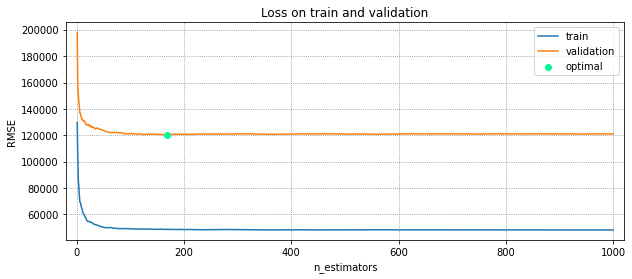

In [17]:
plt.figure(figsize=(10, 4))
plt.title('Loss on train and validation')
max_x = 1000
eps_lim = 20
x_arr = np.arange(1, max_x + 1)
plt.plot(x_arr, train_loss, label='train')
plt.plot(x_arr, val_loss, label='validation')
plt.xlim((-eps_lim, max_x + eps_lim))
plt.xlabel('n_estimators')
plt.ylabel('RMSE')

# optimal x
opt_arg = val_loss.argmin() + 1
plt.scatter(opt_arg, val_loss[opt_arg - 1], marker='o',
            c=opt_color, zorder=3, label='optimal')

plt.legend()
plt.savefig(graph_dir + 'RF_n_estimators_RMSE')

In [18]:
print(f'optimal n_estimators = {opt_arg}, RMSE on optimal n_estimators = {val_loss[opt_arg - 1]}')

optimal n_estimators = 168, RMSE on optimal n_estimators = 120361.83460060255


Получили, что оптимальное число деревьев $=168$. Далее потери на валидации возрастают, начинается переобучение.

In [19]:
n_estimators_opt = opt_arg

Теперь исследуем зависимость времени обучения алгоритма от $n\_estimators$ (возмём с небольшим запасом после оптимального количества). Время будем усреднять за 3 итерации:

In [20]:
n_estimators_arr = [1] + list(range(30, 271, 30))
time_arr = []
k = 3
for n_estimators in tqdm(n_estimators_arr):
    time_ = 0
    for i in range(k):
        start_time = time.time()
        model = RandomForestMSE(n_estimators=n_estimators, random_state=0)
        model.fit(X_train, y_train)
        time_ += time.time() - start_time
    time_arr.append(time_ / k)
np.save(bin_dir + 'RF_n_estimators_time', time_arr, allow_pickle=False)

100%|██████████| 10/10 [06:26<00:00, 38.63s/it]


In [21]:
time_arr = np.load(bin_dir + 'RF_n_estimators_time.npy', allow_pickle=False)

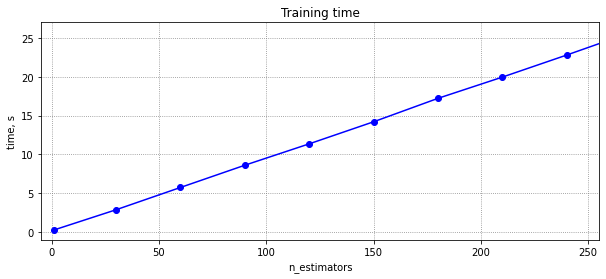

In [22]:
plt.figure(figsize=(10, 4))
max_x = 250
eps_lim = 5
plt.plot(n_estimators_arr, time_arr, marker='o', c='b')
plt.xlim((-eps_lim, max_x + eps_lim))
plt.xlabel('n_estimators')
plt.ylabel('time, s')
plt.title('Training time')
plt.savefig(graph_dir + 'RF_n_estimators_time')

Как видно по графику, время обучения линейно зависит от числа деревьев в ансамбле (интуитивно понятно).

### Зависимость модели от `feature_subsample_size`

Здесь мы, в отличие от случая с количеством деревьев, должны пройтись по сетке количества  признаков для одного дерева (от 1 до всех признаков выборки) и посчитать на каждом: время обучения, потери на обучении и потери на валидации. Сделаем это в цикле:

In [23]:
time_arr, train_loss, val_loss = [], [], []
max_features_arr = list(range(1, X_train.shape[1] + 1))
k = 3
for max_features in tqdm(max_features_arr):
    time_ = 0
    for i in range(k):
        start_time = time.time()
        model = RandomForestMSE(n_estimators=n_estimators_opt, random_state=0,
                            feature_subsample_size=max_features)
        model.fit(X_train, y_train)
        time_ += time.time() - start_time
    time_arr.append(time_ / k)
    train_loss.append(RMSE(y_train, model.predict(X_train)))
    val_loss.append(RMSE(y_val, model.predict(X_val)))
np.save(bin_dir + 'RF_feature_subsample_size_train_RMSE', train_loss, allow_pickle=False)
np.save(bin_dir + 'RF_feature_subsample_size_val_RMSE', val_loss, allow_pickle=False)
np.save(bin_dir + 'RF_feature_subsample_size_time', time_arr, allow_pickle=False)

100%|██████████| 21/21 [25:04<00:00, 71.63s/it] 


In [24]:
train_loss = np.load(bin_dir + 'RF_feature_subsample_size_train_RMSE.npy', allow_pickle=False)
val_loss = np.load(bin_dir + 'RF_feature_subsample_size_val_RMSE.npy', allow_pickle=False)
time_arr = np.load(bin_dir + 'RF_feature_subsample_size_time.npy', allow_pickle=False)

По рассчитанным значениям строим график для RMSE:

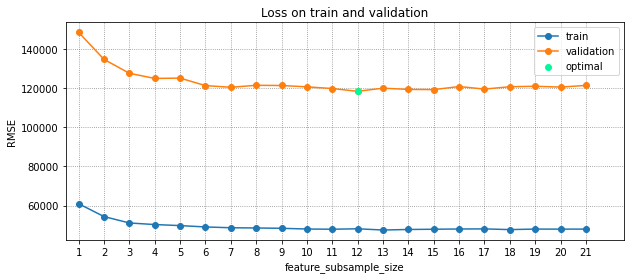

In [25]:
plt.figure(figsize=(10, 4))
plt.title('Loss on train and validation')
max_x = X.shape[1]
eps_lim = 0.5
plt.plot(max_features_arr, train_loss, label='train', marker='o')
plt.plot(max_features_arr, val_loss, label='validation', marker='o')
plt.xticks(ticks=max_features_arr, labels=max_features_arr)
plt.xlim((eps_lim, max_x + eps_lim))
plt.xlabel('feature_subsample_size')
plt.ylabel('RMSE')

# optimal x
opt_arg = np.array(val_loss).argmin() + 1
plt.scatter(opt_arg, val_loss[opt_arg - 1], marker='o',
            c=opt_color, zorder=3, label='optimal')

plt.legend()
plt.savefig(graph_dir + 'RF_feature_subsample_size_RMSE')

Обычно для регрессии берётся треть признаков, но в нашем случае это 12 из 21 признаков, то есть $\approx0.52$ от общего числа признаков дерева

In [26]:
feature_subsample_size_opt = opt_arg

По рассчитанным значениям строим график для времени обучения алгоритма:

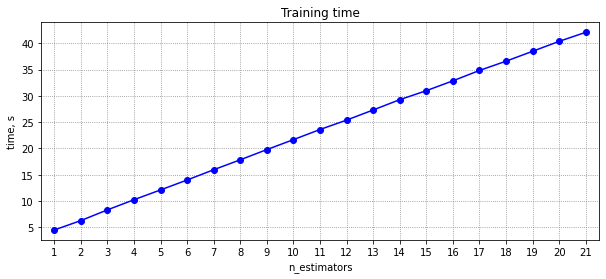

In [27]:
plt.figure(figsize=(10, 4))
max_x = 21
eps_lim = 0.5
plt.plot(max_features_arr, time_arr, marker='o', c='b')
plt.xticks(ticks=max_features_arr, labels=max_features_arr)
plt.xlim((eps_lim, max_x + eps_lim))
plt.xlabel('n_estimators')
plt.ylabel('time, s')
plt.title('Training time')
plt.savefig(graph_dir + 'RF_feature_subsample_size_time')

### Зависимость модели от `max_depth`

In [28]:
time_arr, train_loss, val_loss = [], [], []
max_depths = list(range(1, 25)) + [None]
k = 3
for max_depth in tqdm(max_depths):
    time_ = 0
    for i in range(k):
        start_time = time.time()
        model = RandomForestMSE(n_estimators=n_estimators_opt, random_state=0,
                            feature_subsample_size=feature_subsample_size_opt,
                            max_depth=max_depth)
        model.fit(X_train, y_train)
        time_ += time.time() - start_time
    time_arr.append(time_ / k)
    train_loss.append(RMSE(y_train, model.predict(X_train)))
    val_loss.append(RMSE(y_val, model.predict(X_val)))
np.save(bin_dir + 'RF_max_depth_train_RMSE', train_loss, allow_pickle=False)
np.save(bin_dir + 'RF_max_depth_val_RMSE', val_loss, allow_pickle=False)
np.save(bin_dir + 'RF_max_depth_time', time_arr, allow_pickle=False)

100%|██████████| 25/25 [20:59<00:00, 50.37s/it]


In [29]:
train_loss = np.load(bin_dir + 'RF_max_depth_train_RMSE.npy', allow_pickle=False)
val_loss = np.load(bin_dir + 'RF_max_depth_val_RMSE.npy', allow_pickle=False)
time_arr = np.load(bin_dir + 'RF_max_depth_time.npy', allow_pickle=False)

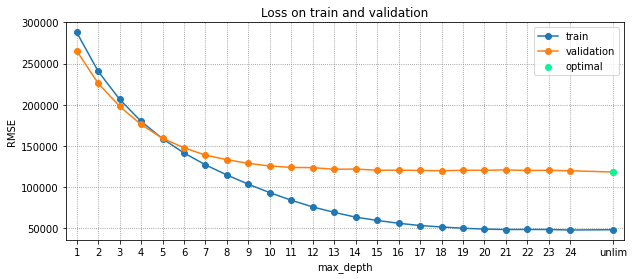

In [30]:
plt.figure(figsize=(10, 4))
plt.title('Loss on train and validation')
max_x = 24
gap = 2
eps_lim = 0.5
x_arr = max_depths[:-1]+[max_x + gap]
plt.plot(x_arr, train_loss, label='train', marker='o')
plt.plot(x_arr, val_loss, label='validation', marker='o')
plt.xticks(ticks=x_arr, labels=max_depths[:-1] + ['unlim'])
plt.xlim((eps_lim, max_x + eps_lim + gap))
plt.xlabel('max_depth')
plt.ylabel('RMSE')

# optimal x
opt_arg = np.array(val_loss).argmin()
plt.scatter(x_arr[opt_arg], val_loss[opt_arg], marker='o',
            c=opt_color, zorder=3, label='optimal')

plt.legend()
plt.savefig(graph_dir + 'RF_max_depth_RMSE')

По графику видно, что потери на валидации падают до достаточного уровня примерно после $max\_depth > 15$, так что можно ограничить глубину для экономии времени (график обучения ниже)
Но в нашем случае оставляем оптимальное значение $-$ глубина неограничена:

In [31]:
max_depth_opt = max_depths[opt_arg]

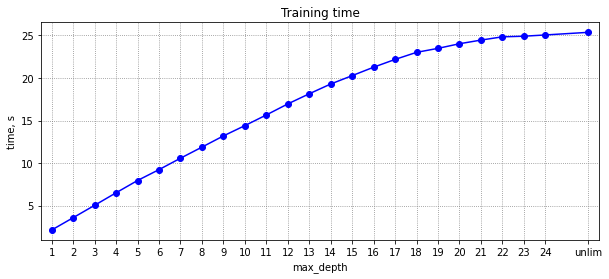

In [32]:
plt.figure(figsize=(10, 4))
plt.title('Training time')
max_x = 24
gap = 2
eps_lim = 0.5
x_arr = max_depths[:-1]+[max_x + gap]
plt.plot(x_arr, time_arr, marker='o', c='b')
plt.xticks(ticks=x_arr, labels=max_depths[:-1]+ ['unlim'])
plt.xlim((eps_lim, max_x + gap + eps_lim))
plt.xlabel('max_depth')
plt.ylabel('time, s')
plt.savefig(graph_dir + 'RF_max_depth_time')

## 3. Градиентный бустинг

Изучим зависимость RMSE на отложенной
выборке и время работы алгоритма в зависимости от следующих факторов:
* количество деревьев в ансамбле (`n_estimators`) $-$ значение по уиолчанию не задано
* размерность подвыборки признаков для одного дерева (`feature_subsample_size`) $-$ по умолчанию, `n // 3`, где n $-$ число признаков выборки
* максимальная глубина дерева (`max_depth`) $-$ по умолчанию, глубина $=5$, также рассматривается случай, когда она неограничена
* темп обучения (`learning_rate`) (каждый новый алгоритм добавляется в композицию с коэффициентом $\alpha~ \cdot$ `learning_rate`) $-$ по умолчанию, темп обучения $=0.1$

Итак:
1. На одном графике мы можем исследовать зависимость $RMSE$ от `n_estimators` на одной выборке, при этом перебирая `learning_rate`. Сделаем так для обучающей и валидационной выборок, после чего замерим время обучения на деревьях в количестве от 1 до {чуть больше оптимального значения}
2. Следующий по важности параметр для подбора $-$ максимальная глубина дерева. Нас интересуют неглубокие деревья, поэтому ограничимся перебором глубины $<10$
3. Далее перебираем размерность подвыборки признаков для одного дерева, от $1$ до общего числа признаков в выборке

### Зависимость модели от `n_estimators` и от `learning_rate`

Обучаем модель и получаем значения функции потерь на обучении и на валидации для ансамблей с количеством деревьев от $1$ до $n\_estimators$. Рассмотрим количество деревьев от 1 до 2000 включительно:

In [33]:
lr_arr = [0.01, 0.05, 0.1, 0.5, 1]
n_estimators_max = 2000
train_loss_arr, val_loss_arr = [], []
for lr in tqdm(lr_arr):
    model = GradientBoostingMSE(n_estimators=n_estimators_max,
                                learning_rate=lr, random_state=0)
    train_loss, val_loss = model.fit(X=X_train, y=y_train,
                                     X_val=X_val, y_val=y_val,
                                     return_train_loss=True,
                                     return_val_loss=True)
    train_loss_arr.append(train_loss)
    val_loss_arr.append(val_loss)

np.save(bin_dir + 'GBM_n_estimators_lr_train_RMSE', train_loss_arr, allow_pickle=False)
np.save(bin_dir + 'GBM_n_estimators_lr_val_RMSE', val_loss_arr, allow_pickle=False)

100%|██████████| 5/5 [05:24<00:00, 64.85s/it]


In [34]:
train_loss_arr = np.load(bin_dir + 'GBM_n_estimators_lr_train_RMSE.npy',
                         allow_pickle=False)
val_loss_arr = np.load(bin_dir + 'GBM_n_estimators_lr_val_RMSE.npy',
                       allow_pickle=False)

best model optimum at 1629


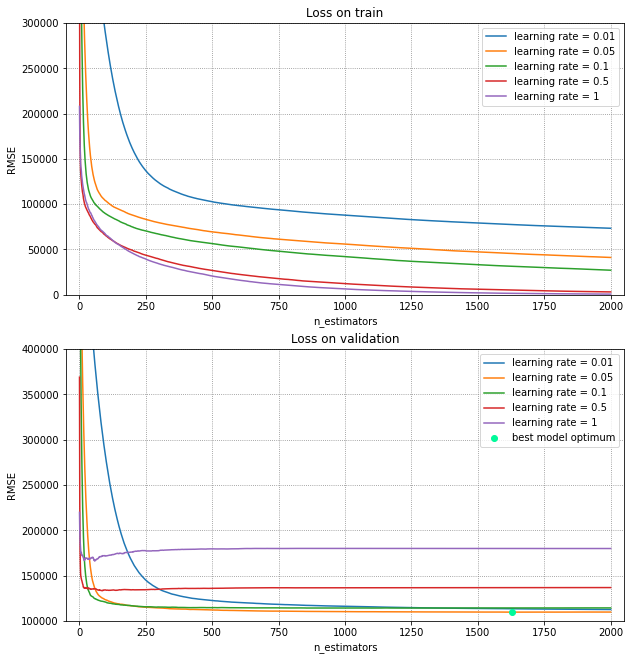

In [35]:
plt.figure(figsize=(10, 11))
max_x = n_estimators_max
eps_lim = 50
x_arr = np.arange(1, n_estimators_max + 1)

plt.subplot(211)
plt.title('Loss on train')
for loss, lr in zip(train_loss_arr, lr_arr):
    plt.plot(x_arr, loss, label=f'learning rate = {lr}')
plt.xlim(-eps_lim, max_x + eps_lim)
plt.ylim(0, 300000)
plt.xlabel('n_estimators')
plt.ylabel('RMSE')
plt.legend()

plt.subplot(212)
plt.title('Loss on validation')
for loss, lr_i in zip(val_loss_arr, lr_arr):
    plt.plot(x_arr, loss,
             label=f'learning rate = {lr_i}')
plt.xlim(-eps_lim, max_x + eps_lim)
plt.ylim(100000, 400000)
plt.xlabel('n_estimators')
plt.ylabel('RMSE')

# optimal x
opt_arg_arr = []
opt_values = []
for loss in val_loss_arr:
    opt_arg = np.array(loss).argmin()
    opt_arg_arr.append(opt_arg)
    opt_values.append(loss[opt_arg])
opt_ind = np.array(opt_values).argmin()
opt_arg = opt_arg_arr[opt_ind]
print(f'best model optimum at {opt_arg}')
plt.scatter(x_arr[opt_arg], val_loss_arr[opt_ind][opt_arg], marker='o',
            c=opt_color, zorder=3, label='best model optimum')

plt.legend()
plt.savefig(graph_dir + 'GBM_n_estimators_lr_RMSE')

Судя по графику, нам **достаточно** модели с $n\_estimators = 750$, $learning\_rate = 0.05$ (оптимум самой точной модели находится в точке 1629, но это много деревьев, долго обучаться, а качество на $750$-ти деревьях близко к оптимальному)

In [36]:
n_estimators_opt, learning_rate_opt = 750, 0.05

In [37]:
n_estimators_arr = [1] + list(range(80, 801, 80))
time_arr = dict(zip(lr_arr, [[], [], [], [], []]))
k = 3
for lr in lr_arr:
    for n_estimators in tqdm(n_estimators_arr):
        time_ = 0
        for i in range(k):
            start_time = time.time()
            model = GradientBoostingMSE(n_estimators=n_estimators,
                                    learning_rate=lr,
                                    random_state=0)
            model.fit(X_train, y_train)
            time_ += time.time() - start_time
        time_arr[lr].append(time_ / k)
np.save(bin_dir + 'GBM_n_estimators_lr_time', time_arr, allow_pickle=True)

100%|██████████| 11/11 [06:57<00:00, 37.91s/it]


In [38]:
np.load(bin_dir + 'GBM_n_estimators_lr_time.npy', allow_pickle=True)

array({0.01: [0.032508293787638344, 2.492004950841268, 4.962552785873413, 7.506592273712158, 9.968513091405233, 12.51564908027649, 15.011995474497477, 17.496577819188435, 19.98807470003764, 22.70785665512085, 25.126997470855713], 0.05: [0.03101325035095215, 2.504662354787191, 5.003241380055745, 7.557050943374634, 10.101483742396036, 12.638093789418539, 15.117603699366251, 17.673998594284058, 20.159188906351726, 22.788902362187702, 25.164369344711304], 0.1: [0.03158386548360189, 2.5224759578704834, 5.049471457799275, 7.641382773717244, 10.1279669602712, 12.658178249994913, 15.213149070739746, 17.6714084148407, 20.251371065775555, 22.750249067942303, 25.285133520762127], 0.5: [0.03182013829549154, 2.5547756354014077, 5.068995396296184, 7.605627059936523, 10.095647970835367, 12.622804800669352, 15.146728674570719, 17.69950858751933, 20.15871278444926, 22.665025631586712, 25.202718655268352], 1: [0.03105473518371582, 2.498826742172241, 5.018371661504109, 7.610527356465657, 10.1479070981343

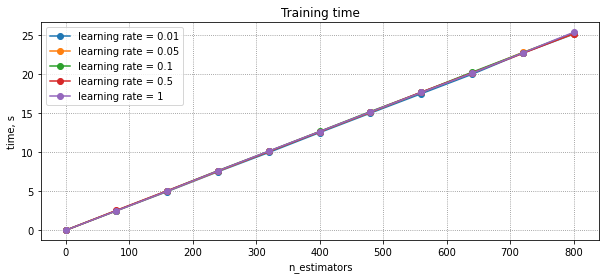

In [39]:
plt.figure(figsize=(10, 4))
plt.title('Training time')
for lr in lr_arr:
    plt.plot(n_estimators_arr, time_arr[lr], marker='o',
             label=f'learning rate = {lr}')
plt.xlabel('n_estimators')
plt.ylabel('time, s')
plt.legend()
plt.savefig(graph_dir + 'GBM_n_estimators_lr_time')

Все графики почти полностью накаладываются друг на друга на представленном масштабе (цвета на предыдущем и на этом графике соответсвуют одним и тем же `learning_rate`), но этого достаточно, чтобы сделать вывод: врем обучения модели градиентного бустинга линейно зависит от `n_estimators` и не зависит от `learning_rate`

### Зависимость модели от `max_depth`

In [40]:
train_loss, val_loss, time_arr = [], [], []
max_depths = list(range(1, 11)) + [None]
k = 3
for max_depth in tqdm(max_depths):
    time_ = 0
    for i in range(k):
        start_time = time.time()
        model = GradientBoostingMSE(n_estimators=n_estimators_opt,
                                    learning_rate=learning_rate_opt,
                                    max_depth=max_depth, random_state=0)
        model.fit(X_train, y_train)
        time_ += time.time() - start_time
    time_arr.append(time_ / k)
    train_loss.append(RMSE(y_train, model.predict(X_train)))
    val_loss.append(RMSE(y_val, model.predict(X_val)))
np.save(bin_dir + 'GBM_max_depth_train_RMSE', train_loss, allow_pickle=False)
np.save(bin_dir + 'GBM_max_depth_val_RMSE', val_loss, allow_pickle=False)
np.save(bin_dir + 'GBM_max_depth_time', time_arr, allow_pickle=False)

100%|██████████| 11/11 [16:33<00:00, 90.28s/it] 


In [41]:
train_loss = np.load(bin_dir + 'GBM_max_depth_train_RMSE.npy', allow_pickle=False)
val_loss = np.load(bin_dir + 'GBM_max_depth_val_RMSE.npy', allow_pickle=False)
time_arr = np.load(bin_dir + 'GBM_max_depth_time.npy', allow_pickle=False)

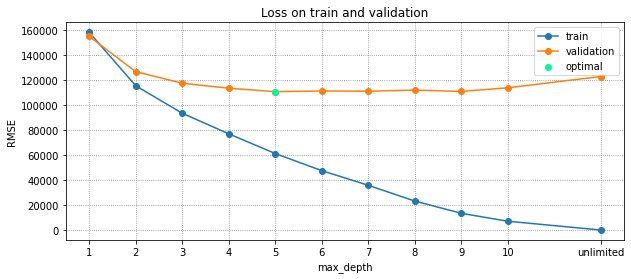

In [42]:
plt.figure(figsize=(10, 4))
plt.title('Loss on train and validation')
max_x = 10
gap = 2
eps_lim = 0.5
x_arr = max_depths[:-1]+[max_x + gap]
plt.plot(x_arr, train_loss, label='train', marker='o')
plt.plot(x_arr, val_loss, label='validation', marker='o')
plt.xticks(ticks=x_arr, labels=max_depths[:-1] + ['unlimited'])
plt.xlim((eps_lim, max_x + gap + eps_lim))
plt.xlabel('max_depth')
plt.ylabel('RMSE')

# optimal x
opt_arg = np.array(val_loss).argmin() + 1
plt.scatter(opt_arg, val_loss[opt_arg - 1], marker='o',
            c=opt_color, zorder=5, label='optimal')

plt.legend()
plt.savefig(graph_dir + 'GBM_max_depth_RMSE')

По графику видно, что оптимальная максимальная глубина деревьев $=5$

In [43]:
max_depth_opt = opt_arg

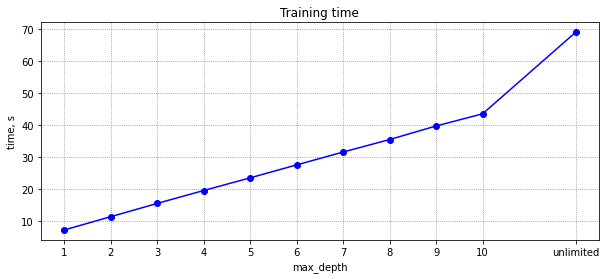

In [44]:
plt.figure(figsize=(10, 4))
plt.title('Training time')
max_x = 10
gap = 2
eps_lim = 0.5
x_arr = max_depths[:-1]+[max_x + gap]
plt.plot(x_arr, time_arr, marker='o', c='b')
plt.xticks(ticks=x_arr, labels=max_depths[:-1] + ['unlimited'])
plt.xlim((eps_lim, max_x + gap + eps_lim))
plt.xlabel('max_depth')
plt.ylabel('time, s')
plt.savefig(graph_dir + 'GBM_max_depth_time')

### Зависимость от `feature_subsample_size`

In [45]:
train_loss, val_loss, time_arr = [], [], []
max_features_arr = list(range(1, X_train.shape[1] + 1))

for max_features in tqdm(max_features_arr):
    time_ = 0
    for i in range(k):
        start_time = time.time()
        model = GradientBoostingMSE(n_estimators=n_estimators_opt,
                                    learning_rate=learning_rate_opt,
                                    max_depth=max_depth_opt, random_state=0,
                                    feature_subsample_size=max_features)
        model.fit(X_train, y_train)
        time_ += time.time() - start_time
    time_arr.append(time_ / k)
    train_loss.append(RMSE(y_train, model.predict(X_train)))
    val_loss.append(RMSE(y_val, model.predict(X_val)))
np.save(bin_dir + 'GBM_feature_subsample_size_train_RMSE', train_loss, allow_pickle=False)
np.save(bin_dir + 'GBM_feature_subsample_size_val_RMSE', val_loss, allow_pickle=False)
np.save(bin_dir + 'GBM_feature_subsample_size_time', time_arr, allow_pickle=False)

100%|██████████| 21/21 [36:55<00:00, 105.51s/it]


In [46]:
train_loss = np.load(bin_dir + 'GBM_feature_subsample_size_train_RMSE.npy', allow_pickle=False)
val_loss = np.load(bin_dir + 'GBM_feature_subsample_size_val_RMSE.npy', allow_pickle=False)
time_arr = np.load(bin_dir + 'GBM_feature_subsample_size_time.npy', allow_pickle=False)

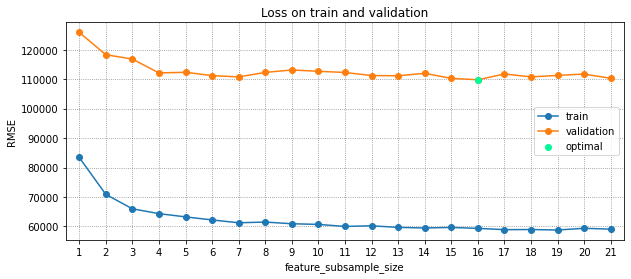

In [47]:
plt.figure(figsize=(10, 4))
plt.title('Loss on train and validation')
max_x = X_train.shape[1]
eps_lim = 0.5
plt.plot(max_features_arr, train_loss, label='train', marker='o')
plt.plot(max_features_arr, val_loss, label='validation', marker='o')
plt.xticks(ticks=max_features_arr, labels=max_features_arr)
plt.xlim((eps_lim, max_x + eps_lim))
plt.xlabel('feature_subsample_size')
plt.ylabel('RMSE')

# optimal x
opt_arg = np.array(val_loss).argmin() + 1
plt.scatter(opt_arg, val_loss[opt_arg - 1], marker='o',
            c=opt_color, zorder=5, label='optimal')

plt.legend()
plt.savefig(graph_dir + 'GBM_feature_subsample_size_RMSE')

Судя по графику, оптимальная размерность подвыборки признаков для одного дерева $=16$

In [48]:
feature_subsample_size_opt = opt_arg

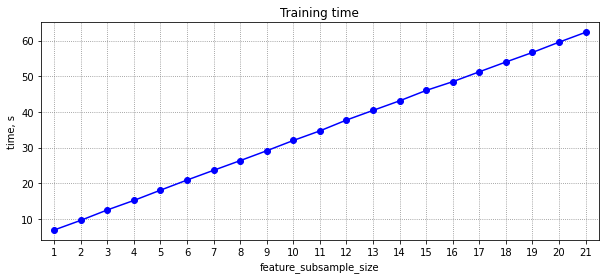

In [49]:
plt.figure(figsize=(10, 4))
plt.title('Training time')
max_x = X_train.shape[1]
gap = 2
eps_lim = 0.5
plt.plot(max_features_arr, time_arr, marker='o', c='b')
plt.xticks(ticks=max_features_arr, labels=max_features_arr)
plt.xlim((eps_lim, max_x + eps_lim))
plt.xlabel('feature_subsample_size')
plt.ylabel('time, s')
plt.savefig(graph_dir + 'GBM_feature_subsample_size_time')

По графику видно, что время обучения градиентного бустинга линейно зависит от размерности подвыборки признаков одного дерева

## Лучший алгоритм

In [50]:
max_n_estimators = 2000

Обучим случайный лес с лучшими параметрами:
* `n_estimators` $= 168$
* `features_subsample_size` $= 12$
* `max_depth` $= None$

In [51]:
model = RandomForestMSE(n_estimators=max_n_estimators,
                        feature_subsample_size=12,
                        max_depth=None,
                        random_state=0)
start_time = time.time()
RF_train_loss, RF_val_loss = model.fit(X=X_train, y=y_train,
                                       X_val=X_val, y_val=y_val,
                                       return_train_loss=True,
                                       return_val_loss=True)
np.save(bin_dir + 'RF_final_train_RMSE', train_loss, allow_pickle=False)
np.save(bin_dir + 'RF_final_val_RMSE', val_loss, allow_pickle=False)
print(f'RF training time: {(time.time() - start_time):.2f} s')

RF training time: 321.39 s


In [52]:
train_loss = np.load(bin_dir + 'RF_final_train_RMSE.npy', allow_pickle=False)
val_loss = np.load(bin_dir + 'RF_final_val_RMSE.npy', allow_pickle=False)

Обучим градиентный бустинг с лучшими параметрами:
* `n_estimators` $= 750$
* `learning_rate` $= 0.05$
* `max_depth` $= 5$
* `features_subsample_size` $= 16$


In [53]:
model = GradientBoostingMSE(n_estimators=max_n_estimators,
                            learning_rate=0.05,
                            max_depth=5,
                            feature_subsample_size=16,
                            random_state=0)
start_time = time.time()
GBM_train_loss, GBM_val_loss = model.fit(X=X_train, y=y_train,
                                       X_val=X_val, y_val=y_val,
                                       return_train_loss=True,
                                       return_val_loss=True)
np.save(bin_dir + 'GBM_final_train_RMSE', train_loss, allow_pickle=False)
np.save(bin_dir + 'GBM_final_val_RMSE', val_loss, allow_pickle=False)
print(f'GBM training time: {(time.time() - start_time):.2f} s')

GBM training time: 131.74 s


In [54]:
train_loss = np.load(bin_dir + 'GBM_final_train_RMSE.npy', allow_pickle=False)
val_loss = np.load(bin_dir + 'GBM_final_val_RMSE.npy', allow_pickle=False)

Построим график функций потерь для моделей **случайного леса** и **градиентного бустинга** для каждого на **обучающей** и на **валидацинной** выборке:

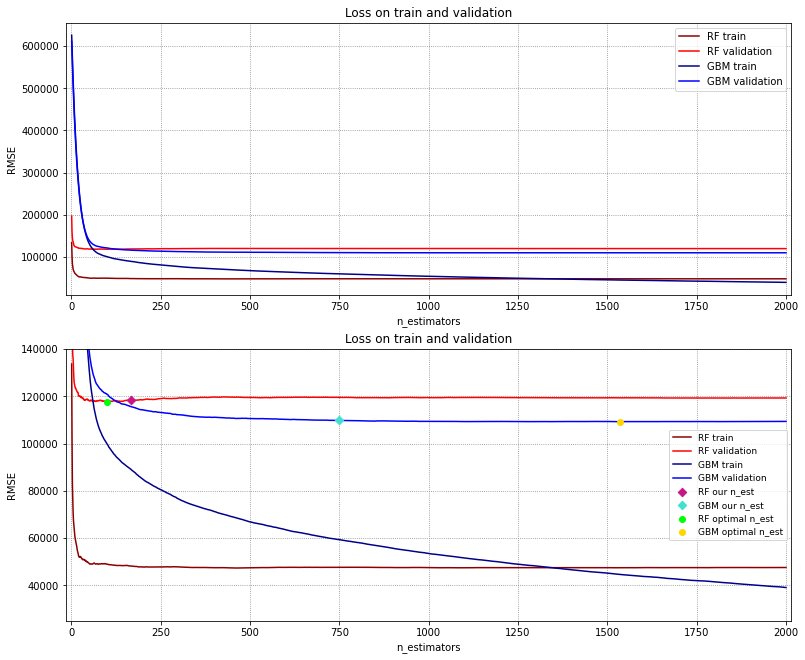

In [56]:
plt.figure(figsize=(13, 11))
eps_lim = 15
loss_arr = [RF_train_loss, RF_val_loss, GBM_train_loss, GBM_val_loss]
labels = ['RF train', 'RF validation', 'GBM train', 'GBM validation']
colors = ['darkred', 'red', 'darkblue', 'blue']
x_arr = list(range(1, max_n_estimators + 1))

plt.subplot(211)
plt.title('Loss on train and validation')
for loss, label_, color_ in zip(loss_arr, labels, colors):
    plt.plot(x_arr, loss, label=label_, color=color_)
plt.xlabel('n_estimators')
plt.ylabel('RMSE')
plt.xlim(-eps_lim, max_n_estimators + eps_lim)
plt.legend()

plt.subplot(212)
plt.title('Loss on train and validation')
for loss, label_, color_ in zip(loss_arr, labels, colors):
    plt.plot(x_arr, loss, label=label_, color=color_)
plt.xlabel('n_estimators')
plt.ylabel('RMSE')
plt.xlim(-eps_lim, max_n_estimators + eps_lim)
plt.ylim(25000, 140000)

# our x
RF_our_arg = 168
plt.scatter(RF_our_arg, RF_val_loss[RF_our_arg - 1], marker='D',
            c='mediumvioletred', zorder=3, label='RF our n_est')
GBM_our_arg = 750
plt.scatter(GBM_our_arg, GBM_val_loss[GBM_our_arg - 1], marker='D',
            c='turquoise', zorder=3, label='GBM our n_est')

# optimal x
RF_opt_arg = RF_val_loss.argmin() + 1
plt.scatter(RF_opt_arg, RF_val_loss[RF_opt_arg - 1], marker='o',
            c='lime', zorder=3, label='RF optimal n_est')
GBM_opt_arg = GBM_val_loss.argmin() + 1
plt.scatter(GBM_opt_arg, GBM_val_loss[GBM_opt_arg - 1], marker='o',
            c='gold', zorder=3, label='GBM optimal n_est')

plt.legend(fontsize=9)
plt.savefig(graph_dir + 'final_RMSE')

In [57]:
print(f'RF (with our n_est = {RF_our_arg}) validation RMSE = {RF_val_loss[RF_our_arg]:.3f}')
print(f'RF (with optimal n_est = {RF_opt_arg}) validation RMSE = {RF_val_loss[RF_opt_arg]:.3f}')
print(f'GBM (with our n_est = {GBM_our_arg}) validation RMSE = {GBM_val_loss[GBM_our_arg]:.3f}')
print(f'GBM (with optimal n_est = {GBM_opt_arg}) validation RMSE = {GBM_val_loss[GBM_opt_arg]:.3f}')

RF (with our n_est = 168) validation RMSE = 118247.218
RF (with optimal n_est = 100) validation RMSE = 117999.428
GBM (with our n_est = 750) validation RMSE = 109819.220
GBM (with optimal n_est = 1536) validation RMSE = 109296.299


Таким образом получили, что при всех, кроме `n_estimators`, лучших подобранных параметрах в моделях существуют `n_estimators`, которые ещё лучше:
* $100$ вместо $168$ в RF
* $1536$ вместо $750$ в GBM ($750$ мы и не брали оптимальным (потому что много деревьев, дольше время обучения), но близким к оптимальному)

**Пояснение**:
1. Сначала были найдены оптимальные `n_estimators` для RF и для GBM при их прочих **стандартных (по умолчанию)** параметрах.
2. Далее были подобраны оптимальные значения остальных параметров (последовательно, в порядке их важности).
3. Заново были найдены `n_estimators` для RF и для GBM при оптимально подобранных в пункте 2 параметрах.

Но всё же брать $1536$ деревьев в GBM $-$ это в два раза увеличить время работы алгоритма по сравнению с теми же $750$-ю деревьями при улучшении качества всего на $\left(1 - \frac{109296.299}{109819.220}\right) \cdot 100\% \approx 0.48\%$.

То есть в production гораздо лучше взять модель, которая работает в два раза быстрее development-версии, но чуть (или даже не чуть) хуже качеством. Вроде бы так и делают. А судя по графику потерь GBM на валидации, как раз примерно с $750$-ти деревьев и начинается **достаточный** уровень качества модели.

Тогда остановимся на том, что:
* У RF оптимальное число деревьев $= 100$ и для development-версии, и для production-версии. 
* У GBM оптимальное число деревьев $= 1536$ для development-версии и $= 750$ для production-версии.

Прочие оптимальные параметры одинаковы и не изменялись. 

**Итого**:
* Лучшие development-параметры:
  * RF ($RMSE \approx 117999$):
    * `n_estimators` $= 100$
    * `features_subsample_size` $= 12$
    * `max_depth` $= None$
  * GBM ($RMSE \approx 109296$):
    * `n_estimators` $= 1536$
    * `learning_rate` $= 0.05$
    * `max_depth` $= 5$
    * `features_subsample_size` $= 16$

* Лучшие production-параметры:
  * RF ($RMSE \approx 117999$):
    * `n_estimators` $= 100$
    * `features_subsample_size` $= 12$
    * `max_depth` $= None$
  * GBM ($RMSE \approx 109819$):
    * `n_estimators` $= 750$
    * `learning_rate` $= 0.05$
    * `max_depth` $= 5$
    * `features_subsample_size` $= 16$
